# Landcover fractions (Trees, Grass, Bare)

Following [Donohue 2009](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2486.2008.01746.x)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings

## Analysis Parameters

In [2]:
# enter NDVI value of bare soil
ndvi_min = 0.141

# likely maximum NDVI
ndvi_max = 0.91

#ndvi data is here
ndvi_path = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/NDVI_5km_monthly_1982_2022.nc'

## Open data

In [3]:
ds = xr.open_dataarray(ndvi_path)

## Calculate landcover fractions

In [4]:
#calculate f-total
ft = (ds - ndvi_min) / (ndvi_max - ndvi_min)
ft = xr.where(ft<0, 0, ft)
ft = xr.where(ft>1, 1, ft)

#calculate initial persistent fraction (equation 1 & 2 in Donohue 2009)
persist = ft.rolling(time=7, min_periods=1).min()
persist = persist.rolling(time=9, min_periods=1).mean()

#calculate initial recurrent fraction (equation 3 in Donohue 2009)
recurrent = ft - persist

###------- equations 4 & 5 in Donohue 2009----------------
persist = xr.where(recurrent<0, persist - np.abs(recurrent), persist) #eq4
recurrent = ft - persist # eq 5
## ---------------------------------------------------------

#ensure values are between 0 and 1
persist = xr.where(persist<0, 0, persist)
recurrent = xr.where(recurrent<0, 0, recurrent)

#assign variable names
recurrent.name='grass'
persist.name='trees'

## Plots

Check how the fractions look for any given year

In [5]:
year='2020'

In [6]:
p = persist.sel(time=year).max('time')
r = recurrent.sel(time=year).max('time')
b = 1-(p+r)

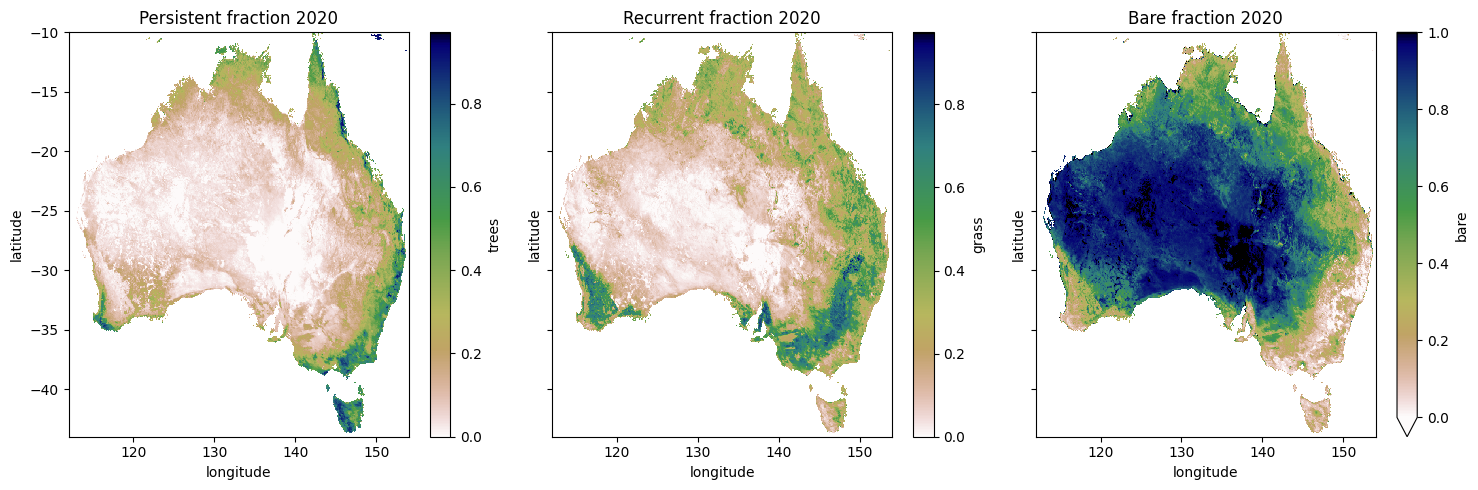

In [7]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True)
p.plot.imshow( ax=ax[0], cmap='gist_earth_r') #vmax=1, vmin=0,
r.plot.imshow(ax=ax[1], cmap='gist_earth_r')
b.rename('bare').plot.imshow(ax=ax[2], vmin=0, cmap='gist_earth_r')

ax[0].set_title('Persistent fraction '+year)
ax[1].set_title('Recurrent fraction ' +year)
ax[2].set_title('Bare fraction ' +year)
plt.tight_layout()

### Plot Aus-wide time-series

Text(0.5, 1.0, 'Mean fractions across Australia')

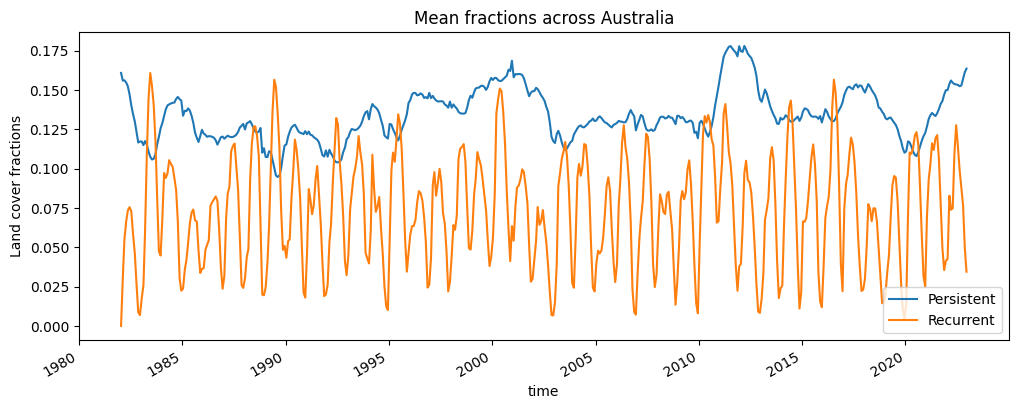

In [8]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
persist.mean(['latitude', 'longitude']).plot(ax=ax, label='Persistent')
recurrent.mean(['latitude', 'longitude']).plot(ax=ax, label='Recurrent')
ax.legend()
plt.ylabel('Land cover fractions')
plt.title('Mean fractions across Australia')

# bare.mean(['latitude', 'longitude']).plot(ax=ax, label='bare')

## Aggregate to annual layers

Use the maximum fraction of trees and grass to create annual layers.

Bare soil is the residual

In [9]:
persist_annual = persist.resample(time='1Y').max()
recurrent_annual = recurrent.resample(time='1Y').max()
bare_annual = 1-(persist_annual+recurrent_annual)
bare_annual.name='bare'

### Export annual files 

In [10]:
# persist_annual.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_annual_1982_2022.nc')
# recurrent_annual.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/grass_5km_annual_1982_2022.nc')
# bare_annual.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/bare_5km_annual_1982_2022.nc')

## Create monthly timeseries for the flux modelling

In [11]:
import pandas as pd
from odc.geo.xr import assign_crs

In [12]:
dss_trees=[]
dss_grass=[]
dss_bare=[]
for y in bare_annual.time.dt.year.values:
    # print(y)
    y = str(y)
    time = pd.date_range(y+"-01", y+"-12", freq='MS') 
    time = [t+pd.Timedelta(14, 'd') for t in time]

    #trees
    ds_persist = persist_annual.sel(time=y).squeeze().drop('time')
    ds_persist = ds_persist.expand_dims(time=time)
    dss_trees.append(ds_persist)

    #grass
    ds_recurrent = recurrent_annual.sel(time=y).squeeze().drop('time')
    ds_recurrent = ds_recurrent.expand_dims(time=time)
    dss_grass.append(ds_recurrent)

    ds_bare = bare_annual.sel(time=y).squeeze().drop('time')
    ds_bare = ds_bare.expand_dims(time=time)
    dss_bare.append(ds_bare)

# join all the datasets back together
trees = xr.concat(dss_trees, dim='time').sortby('time')
grass = xr.concat(dss_grass, dim='time').sortby('time')
bare = xr.concat(dss_bare, dim='time').sortby('time')

# add right metadata
trees.attrs['nodata'] = np.nan
grass.attrs['nodata'] = np.nan
bare.attrs['nodata'] = np.nan

trees = assign_crs(trees, crs='EPSG:4326')
grass = assign_crs(grass, crs='EPSG:4326')
bare = assign_crs(bare, crs='EPSG:4326')


### Export data

In [13]:
# trees.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/trees_5km_monthly_1982_2022.nc')
# grass.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/grass_5km_monthly_1982_2022.nc')
# bare.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/bare_5km_monthly_1982_2022.nc')

# Calculating C4 grass cover percentage

Method from here: https://researchdata.edu.au/australian-c4-grass-cover-percentage/2305833

These data describe the percent of the total grass foliage cover that is comprised of the cover from C4 grasses. It is a long-term average (2001-2021) derived from MODIS imagery. Percent values range between 10 to 95%. Data have a spatial resolution of 0.0025 decimal degrees (~250 m). No quantitative validation has been performed but only a qualitative comparison to site and mapped information. Note that this is not the foliage cover of C4 grasses, nor the relative abundance of C4 plants, but the percent of total grass foliage cover that comes from C4 plants. So, for example, if total grass foliage cover is 60% and the C4 percentage is 80%, then the C4 foliage cover would be 48% (i.e., 60% x 0.8) and the C3 grass foliage cover would be 12%..

In [14]:
import rioxarray as rxr

import sys
sys.path.insert(1, '/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.temporal import xr_phenology

sys.path.append('/g/data/os22/chad_tmp/climate-carbon-interactions/src/')
from _collect_prediction_data import round_coords

### Smooth the recurrent timeseries

This will help with phenology metrics

In [15]:
window=4

recurrent_smooth = recurrent.resample(time="2W").interpolate("linear")
recurrent_smooth=recurrent_smooth.rolling(time=window, min_periods=1).mean()
# recurrent_clim = recurrent.sel(time=slice('2001', '2020')).groupby('time.month').mean()

## Calculate annual phenology statistics

In [16]:
warnings.simplefilter('ignore')
doy = recurrent_smooth.groupby('time.year').map(xr_phenology)

### Plot trend in average DOY of peak grass fraction

Text(0.5, 1.0, 'Average Day-of-Year for annual peak recurrent vegetation fraction')

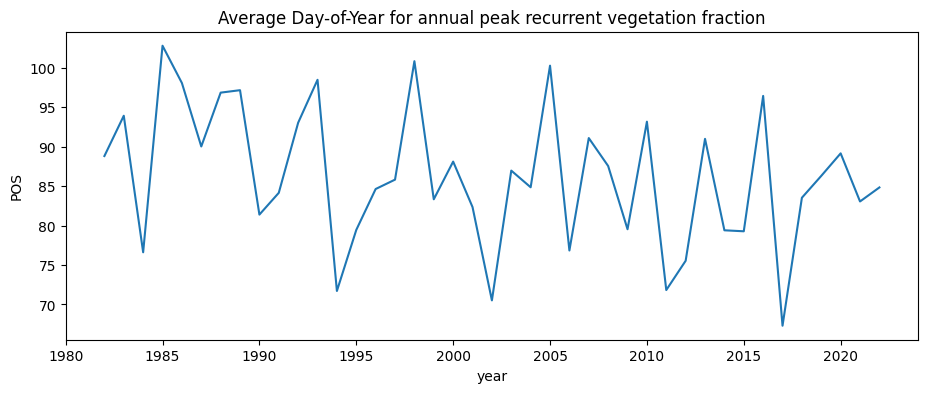

In [17]:
doy.POS.mean(['latitude', 'longitude']).plot(figsize=(11,4))
plt.title('Average Day-of-Year for annual peak recurrent vegetation fraction')

## Calculate C4 abundance

The C4 percent data have been derived from MOD09Q1 (collection 6) NDVI data. 16-day NDVI data were converted to percent foliage cover using the method of Donohue et al. (2014) and then split into separate tree and grass (persistent and recurrent) components following Donohue et al. (2009). The long-term average grass cover for each 16-day period was calculated (2001 to 2020) and were then used to identify the average day-of-year (DOY) of maximum cover. This average timing was used to estimate the percent of C4 cover based on the understanding that C3 grasses have peak growth (cover) in late autumn/early summer, and C4 in late summer. Using Tasmanian native grasslands (10% C4) and Queensland’s Mitchel grasslands (95% C4) as end points (Hattersley, 1983), the timing of minimum and maximum C4 cover was determined as DOY 17 and 307, respectively. The percent of C4 was then scaled linearly between these two end points9C.

Using Tasmanian native grasslands (10% C4) and Queensland’s Mitchel grasslands (95% C4) as end points (Hattersley, 1983), the timing of minimum and maximum C4 cover was determined as DOY 17 and 307, respectively. The percent of C4 was then scaled linearly between these two end points.

In [18]:
doy_max = 17
doy_min = 307

doy_max_alpine = 65

In [19]:
# Linearly scale values between the min DOY
c4_frac = (doy['POS'] - doy_min) / (doy_max - doy_min)

# set min as 10% and max as 95%
c4_frac = xr.where(c4_frac<0.10, 0.10, c4_frac)
c4_frac = xr.where(c4_frac>0.95, 0.95, c4_frac)

### More filtering

Locations with peak growth over the austral summer between these two dates were assigned to either minimum or maximum C4 percent depending on whether the average January air temperature was below or above 22C, respectively, according to Collatz et al. (1998). The summer cropping regions of NSW and Queensland are the main areas where locations fell between these two dates and represent the regions of lowest accuracy.

#### Masking where peak growth in in summer

In [20]:
# Use air temp dataset, create a mask where average air temperature of january is above/below 22C
temp = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/tavg_5km_monthly_1982_2022.nc')['tavg']
temp = temp.groupby('time.month').mean().sel(month=1).rename('jan_avg_temp')
temp_mask = xr.where(temp>22, 1, 0) #1=above 22C, 0=below 22C

# find regions where the annual peak falls between 307 and 17 (summer)
summer_peak = xr.where((doy['POS'] < doy_max) | (doy['POS'] > doy_min),  1, 0)

# create annual masks where peak is in summer, but average Jan air temp is above and below 22C
summer_peak_warm_mask = xr.where((summer_peak==1) & (temp_mask==1), 1, 0)
summer_peak_cool_mask = xr.where((summer_peak==1) & (temp_mask==0), 1, 0)

# wherever these mask are True, set c4_frac values to either max or min c4_frac
c4_frac = xr.where(summer_peak_warm_mask==1, 0.95, c4_frac) #where its warm, set to max
c4_frac = xr.where(summer_peak_cool_mask==1, 0.10, c4_frac)

#### Masking alpine regions

NOT SURE ABOUT THIS APPROACH...so commented out for now

An additional condition was introduced to force alpine grasslands to have minimal C4 percent values. This was done by changing the date of peak C4 cover from DOY 17 to DOY 65 wherever January air temperatures were below 19C.

In [21]:
# cold_mask = xr.where(temp<18, 1, 0)

# # Linearly scale values between the min DOY
# c4_frac_alpine = (doy['POS'] - doy_min) / (doy_max_alpine - doy_min)

# # set min as 10% and max as 95%
# c4_frac_alpine = xr.where(c4_frac_alpine<0.10, 0.10, c4_frac_alpine)
# c4_frac_alpine = xr.where(c4_frac_alpine>0.95, 0.95, c4_frac_alpine)

# # mask for the cold areas (alpine+tassie)
# c4_frac_alpine = c4_frac_alpine.where(cold_mask)

# #replace with alpine values 
# c4_frac = xr.where((~np.isnan(c4_frac_alpine)), c4_frac_alpine, c4_frac)

ocean_mask = (~np.isnan(temp))
c4_frac = c4_frac.where(ocean_mask)
c4_frac = assign_crs(c4_frac, crs='epsg:4326')

## Plots

### Compare with Donohue (2021)

In these plost, Donohue's product is based on the long-term average grass cover for each 16-day period, calculated 2001 to 2020, and were  used to identify the average day-of-year (DOY) of maximum cover. This study's C4 fractions are calculated annually, and then averaged over the same period - so its not quite like-for-like

In [22]:
c4_dono = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/grass/peak_frec_C4_percent.tif').squeeze().drop('band')
c4_dono = assign_crs(c4_dono, crs='epsg:4326')
c4_dono = c4_dono.odc.reproject(c4_frac.odc.geobox, resampling='average')
c4_dono = c4_dono/100 #convert to fraction
c4_dono = round_coords(c4_dono)
c4_dono = c4_dono.where(ocean_mask)

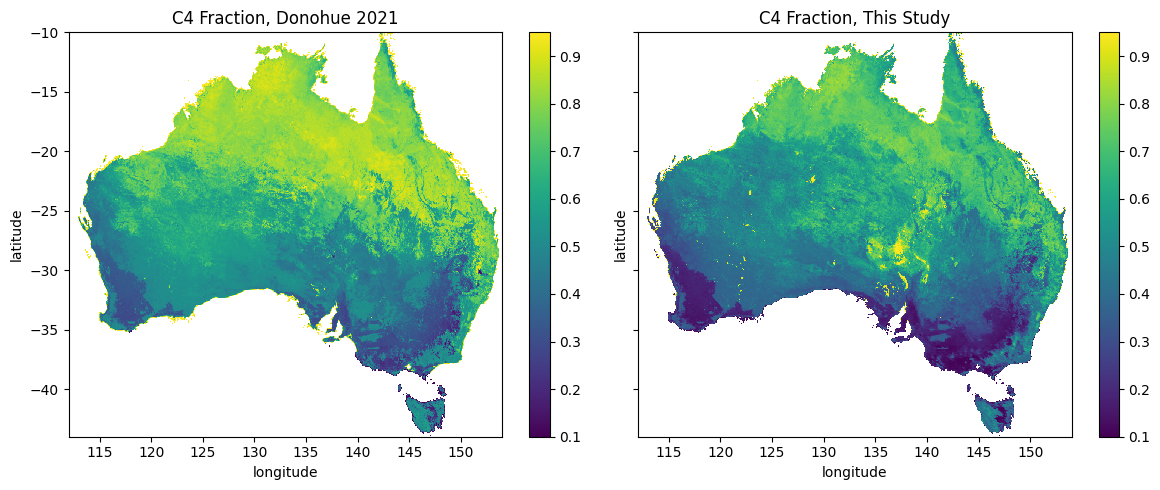

In [23]:
fig,ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
c4_dono.plot.imshow(vmin=0.1, vmax=0.95, ax=ax[0])
c4_frac.sel(year=slice('2001', '2020')).mean('year').plot.imshow(vmin=0.1, vmax=0.95, ax=ax[1])
ax[0].set_title('C4 Fraction, Donohue 2021')
ax[1].set_title('C4 Fraction, This Study')
plt.tight_layout()

### Time-series average over Aus

Annual area dominated by C4 grass

In [24]:
grid = c4_frac.odc.geobox.to_crs('EPSG:3577')
c4_frac_albers = c4_frac.odc.reproject(how=grid, resampling='bilinear')

In [25]:
area_per_pixel = c4_frac_albers.geobox.resolution[1]**2

annual_area_c4 = (c4_frac_albers.where(c4_frac_albers>0.5).sum(['x', 'y']))*area_per_pixel*1e-6

Text(0, 0.5, 'Area (km2)')

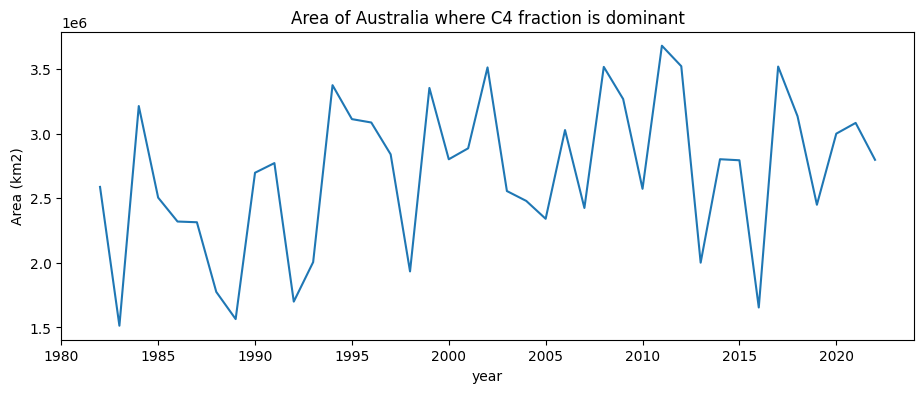

In [26]:
annual_area_c4.plot(figsize=(11,4))
plt.title('Area of Australia where C4 fraction is dominant')
plt.ylabel('Area (km2)')

## C3/C4 Percent

We need to multiply the C3/C4 datasets by the fraction grass. 

```
Fraction_C4 = C4_data_you_have * Fraction_Grass

Fraction_C3 = (1. - C4_data_you_have) * Fraction_Grass

The C4_data_you_have has values 10-95.  Simply divide by 100 to get into proportion.
```


### Fraction C3/C4

In [27]:
# c3_grass = ds*grass
# c4_grass = (1 - ds) * grass
# c4_grass = c4_grass.rename('C4_grass')
# c4_grass.attrs['nodata']=np.nan